<h1> <center> Project work in Deep Learning </center> </h1>
<h2> <center> Song Classification Into Genres Based on Lyrics </center> </h2>

<h3> Student: Dinno Koluh (0001034376)</h3>

<h4> Introduction </h4>
<p>
In this project we are going classify songs into genres based on their lyrics. This is inherently a task in the area of NLP (Natural Language Processing), more specifically a <i>text classification</i> problem. In our case the text to be classified is the song lyrics and the different classes are the different genres. This task has substantial real-world usage application as the big music platforms (e.g. Spotify, Deezer, SoundCloud, Apple Music...) are exposed to this task on a daily basis. Even though most classification models on this problem use the sound of the songs as the data we will try to see could also lyrics play a role. Inherently this is a difficult task (more info can be find <a url="https://arxiv.org/pdf/1707.04678.pdf"> here</a>) as a lot of song lyrics might overlap in genres (e.g. a rock, jazz, or indie song might have texts about love or sadness) in contrast to, for example, sentiment analysis as we have a clear distinction between classes.
</p>

<h4> Dataset </h4>

The used dataset was obtained from Kaggle (it can be found <a url="https://www.kaggle.com/datasets/mateibejan/multilingual-lyrics-for-genre-classification"> here</a>). The dataset is comprised of ~300,000 samples with the following features: artist, song title, genre, language, lyrics. During the preprocessing phase we are going reduce the dataset as it is imbalanced and contains noisy data. We will address the issues and the respective solutions in the relevant section.

<h4> Architecture to be used </h4>

The go-to architecture for NLP tasks used to be RNNs (Recurrent Neural Networks) and their modifications (LSTM, GRU) as we are dealing with sequential data. RNNs are able to capture contextual information as they are able to store information from previous inputs (they have a limited amount of memory). But this fact is also a bottleneck as RNNs have long-term dependency issues (information about a fact stated at the beginning of a document is lost at some point) and they are inefficient when training as it is hard to parallelize them to use the massive power of GPUs for training.

Nowadays the most popular architecture used in NLP tasks is the Transformer. The two problems RNNs have, the Transformer model solves using the <i> attention </i> mechanism which enables to capture dependencies between distant words in text and input sequences can be processed in parallel making the Transformer model highly efficient. We are going to use the BERT(Bidirectional Encoder Representations from Transformer) language model, more specifically we will build a neural network on top of the BERT model and use it's hidden states as the input for the NN network and classify the songs. We are going to dive more into the architecture of BERT and the NN when we start to build the model for the classification task.

In [55]:
!pip install transformers
!pip install contractions
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
import contractions
import re
from ast import literal_eval
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
# NN importing
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling1D, Dropout
from tensorflow.keras.models import Model
from transformers import TFAutoModel, AutoTokenizer, TFBertModel

In [ ]:
nltk.download("wordnet") # package for the needs of the nltk library

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\pc\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

<h4> Data preprocessing </h4>

In [ ]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

In [ ]:
df_train

,Artist,Song,Genre,Language,Lyrics
0,12 stones,world so cold,Rock,en,"It starts with pain, followed by hate\nFueled ..."
1,12 stones,broken,Rock,en,Freedom!\nAlone again again alone\nPatiently w...
2,12 stones,3 leaf loser,Rock,en,"Biting the hand that feeds you, lying to the v..."
3,12 stones,anthem for the underdog,Rock,en,You say you know just who I am\nBut you can't ...
4,12 stones,adrenaline,Rock,en,My heart is beating faster can't control these...
...,...,...,...,...,...
291121,bobby womack,i wish he didn t trust me so much,R&B,en,I'm the best friend he's got I'd give him the ...
291122,bad boys blue,i totally miss you,Pop,en,"Bad Boys Blue ""I Totally Miss You"" I did you w..."
291123,celine dion,sorry for love,Pop,en,Forgive me for the things That I never said to...
291124,dan bern,cure for aids,Indie,en,The day they found a cure for AIDS The day the...


We will only work on songs in English, so we will keep only samples in English. After this step we can also drop the language column as it not necessary anymore.

In [ ]:
en_df_train = df_train[df_train["Language"] == 'en'] # removing non-english languages
df_train = en_df_train.drop(columns='Language') # language column now more needed

Let us now get the unique genres in the genre columns. There will be some noisy data, so we will filter it and just keep the genres that make sense. We will construct a dictionary where the keys will be the genres and the values are the dataframes.

In [ ]:
genres = df_train['Genre'].unique() # there is some noisy data
print(genres)
genres = ['Rock', 'Metal', 'Pop', 'Indie', 'R&B', 'Electronic', 'Jazz', 'Hip-Hop', 'Country'] # the genres that we will keep

data_train = {} # dictionary of genres used as keys
data_test = {}
train_samples = 0 # number of samples
test_samples = 0
for g in genres:
    data_train[g] = df_train[df_train["Genre"] == g]
    data_test[g] = df_test[df_test["Genre"] == g]
    train_samples += len(data_train[g])
    test_samples += len(data_test[g])
print("Number of training samples: " + str(train_samples))
print("Number of test samples: " + str(test_samples))

['Rock' 'Metal' 'Pop' 'Indie' 'Folk' 'Electronic' 'R&B' 'Jazz' 'Hip-Hop'
 'Country']


Number of training samples: 242027
Number of test samples: 7440


Let us now inspect the obtained data. For training purposes we should have balanced data across the different classes. So, let us see how classes compare to each other.

In [ ]:
def print_data(data, n_samples):
    for key in data.keys():
        print("Music genre: {}. Number of samples: {}. Percentage of dataset: {}.\n".format(key, len(data[key]), 100*len(data[key])/n_samples))
print_data(data_train, train_samples)

Music genre: Rock. Number of samples: 107145. Percentage of dataset: 44.2698541898218.

Music genre: Metal. Number of samples: 19133. Percentage of dataset: 7.905316349002384.

Music genre: Pop. Number of samples: 86297. Percentage of dataset: 35.655939213393545.

Music genre: Indie. Number of samples: 7240. Percentage of dataset: 2.9914017857511763.

Music genre: R&B. Number of samples: 2765. Percentage of dataset: 1.1424345217682326.

Music genre: Electronic. Number of samples: 2005. Percentage of dataset: 0.8284199696728051.

Music genre: Jazz. Number of samples: 13314. Percentage of dataset: 5.50103914026121.

Music genre: Hip-Hop. Number of samples: 2238. Percentage of dataset: 0.9246902205125874.

Music genre: Country. Number of samples: 1890. Percentage of dataset: 0.7809046098162602.



We see that the data is unbalanced to a great extent. Rock and Pop are the most present genres whereas Country and Electronic music are the least present. To keep data at a large enough level, we will drop the Country and Electronic genres and downsize other genres to about $2500$ random samples to keep the dataset balanced. We will also drop the Pop and R&B genres as they clash to a great extent with other genres and contain a lot of noise (after manual inspection a lot of the Pop samples were misclassified as Rock and Hip-Hop).

In [ ]:
# deleting the two least present genres
del data_train['Electronic']
del data_train['Country']
del data_train['Pop']
del data_train['R&B']

del data_test['Electronic']
del data_test['Country']
del data_test['Pop']
del data_test['R&B']

In [ ]:
# new number of samples after deleting the unwanted classes
train_samples = 0
test_samples = 0
for key in data_train.keys(): train_samples+=len(data_train[key])
for key in data_test.keys(): test_samples+=len(data_test[key])

In [ ]:
genres = ['Rock', 'Metal', 'Indie', 'Jazz', 'Hip-Hop'] # the genres that we will keep
n = len(genres)
train_samples = 0
for g in genres:
    if g == 'Hip-Hop':
        train_samples += len(data_train[g])
        continue
    data_train[g] = data_train[g].sample(n=2500, random_state=0)
    train_samples += len(data_train[g])
print_data(data_train, train_samples)

Music genre: Rock. Number of samples: 2500. Percentage of dataset: 20.428174538323255.

Music genre: Metal. Number of samples: 2500. Percentage of dataset: 20.428174538323255.

Music genre: Indie. Number of samples: 2500. Percentage of dataset: 20.428174538323255.

Music genre: Jazz. Number of samples: 2500. Percentage of dataset: 20.428174538323255.

Music genre: Hip-Hop. Number of samples: 2238. Percentage of dataset: 18.287301846706978.



We now have a decently balanced dataset, so we can proceed with some text preprocessing. Let us look at the lyrics of the first rock song to get the idea of the text we are working with:

In [ ]:
print(data_train['Rock']['Lyrics'].iloc[0])

She was my lover
She was working undercover
Oh the woman knew all of the moves
She really had me rompin'
We were barefoot stompin'
She just kept igniting my fuse

I was blinded by the blackness
Of her long silk stockings
She was rocking with an optical illusion
This ain't how I'd thought it'd be
She just kept on keeping me
In a total state of confusion

She took me for a ride
Rattled me down to my shoes
And I found out
She was an undercover agent for the blues

She never really needed love
Omnidirectional
I was just an innocent bystander
She kept on getting kinkier
I sank hook, line, and sinker
Just, just, just too hot to handle

She took me by storm
It must of been a season for the fools
She's so bad
An undercover agent for the blues



We will now normalize the text. We are going to do the following:
<br>
- Tokenize the text
- Expand token contractions ('cause $\rightarrow$ because)
- Convert all characters to lowercase
- Remove punctuation signs
</br>

We won't do word lemmatization or stop-word removal as our model of choice is the Transformer which benefits from both, fully expanded tokens and also stop-words as they give context to text. One more aspect to address would be to do sentence-level (divide the text into verses and the verses then into tokens) or token-level (divide the whole text just into tokens) classification with transformers. After going through some papers, and taking into account the size of the final model (using sentence-level classification will require more padding, hence a larger model) we will use token-level classification.

So, the following function normalizes the lyrics (we can see an example of how the normalized lyrics of the before mentioned rock song would look like):

In [ ]:
def normalize_lyrics(lyrics):
  expanded_words = []
  for word in lyrics.split():
    # using contractions to expand the shortened words
    expanded_words.append(contractions.fix(word))

  expanded_lyrics = ' '.join(expanded_words)
  expanded_lyrics = re.sub(r"in'", "ing", expanded_lyrics) # taking into account verbs that end in "in'", singin' -> singing

  tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+') # remove punctuations and other non-alphanumeric characters
  tokens = tokenizer.tokenize(expanded_lyrics) # using the nltk toknizer to split the lyrics into tokens

  tokens = [token.lower() for token in tokens] # lowering tokens
  return tokens

lyrics = data_train['Rock']['Lyrics'].iloc[0]
print(normalize_lyrics(lyrics))

['she', 'was', 'my', 'lover', 'she', 'was', 'working', 'undercover', 'oh', 'the', 'woman', 'knew', 'all', 'of', 'the', 'moves', 'she', 'really', 'had', 'me', 'romping', 'we', 'were', 'barefoot', 'stomping', 'she', 'just', 'kept', 'igniting', 'my', 'fuse', 'i', 'was', 'blinded', 'by', 'the', 'blackness', 'of', 'her', 'long', 'silk', 'stockings', 'she', 'was', 'rocking', 'with', 'an', 'optical', 'illusion', 'this', 'are', 'not', 'how', 'i', 'would', 'thought', 'it', 'would', 'be', 'she', 'just', 'kept', 'on', 'keeping', 'me', 'in', 'a', 'total', 'state', 'of', 'confusion', 'she', 'took', 'me', 'for', 'a', 'ride', 'rattled', 'me', 'down', 'to', 'my', 'shoes', 'and', 'i', 'found', 'out', 'she', 'was', 'an', 'undercover', 'agent', 'for', 'the', 'blues', 'she', 'never', 'really', 'needed', 'love', 'omnidirectional', 'i', 'was', 'just', 'an', 'innocent', 'bystander', 'she', 'kept', 'on', 'getting', 'kinkier', 'i', 'sank', 'hook', 'line', 'and', 'sinker', 'just', 'just', 'just', 'too', 'hot', 

Let us now do this for all samples and all categories. We will also make a new data column "Tokens" which will contain the tokenized lyrics. This way we can save the dataframes as csv files and when loading them in future we get immediately the tokenized lyrics.

In [ ]:
def tokenize_dict(data):
    for key in data.keys():
        genre_tokens = []
        index_to_drop = []
        for i in range(len(data[key])):
            tokenized_lyrics = normalize_lyrics(data[key]['Lyrics'].iloc[i])
            # if there are less than 10 tokens inside a lyrics consider it as noise and don't include it
            if len(tokenized_lyrics) < 10:
                index_to_drop.append(data[key].index[i])
                continue
            genre_tokens.append(tokenized_lyrics)
        for ind in index_to_drop:
            data[key] = data[key].drop(axis=1, index=ind) # drop based on the index of row
        data[key]['Tokens'] = genre_tokens
    return data

In [ ]:
data_train = tokenize_dict(data_train)
data_test = tokenize_dict(data_test)

C:\Users\pc\AppData\Local\Temp\ipykernel_12880\471414185.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[key]['Tokens'] = genre_tokens
C:\Users\pc\AppData\Local\Temp\ipykernel_12880\471414185.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[key]['Tokens'] = genre_tokens
C:\Users\pc\AppData\Local\Temp\ipykernel_12880\471414185.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

For the purpose of reusing the dataset we will save train and test data so to be able to load it without going through the preprocessing steps in the future.

In [ ]:
def combine_dfs(data):
    dfs = []
    for key in data.keys(): dfs.append(data[key])
    return pd.concat(dfs)
combine_dfs(data_test).to_csv('data/pruned_test.csv', index=False)
combine_dfs(data_train).to_csv('data/pruned_train.csv', index=False)

<h4> Model architecture </h4>

Before addressing the architecture of the model, let us load the pruned data. As all the inputs to an NN when training have to have the same input length we will need to take a threshold for the number of tokens used per sample. We will go with 200 tokens, and for songs that have fewer tokens than that number, they are going to be padded.

We need to also address the labels. As we have chosen to work with five genres in the end, we will have five classes but for now they are just strings representing the name of the specific genre. For training the purposes we need to use one-hot encoding to represent the different classes.

All of this is done by the following function which gives us ready-to-use training and testing data.

In [3]:
genres = ['Rock', 'Metal', 'Indie', 'Jazz', 'Hip-Hop']
n = len(genres)
def load_data(max_len=200):
    train = pd.read_csv('pruned_train.csv')
    test = pd.read_csv('pruned_test.csv', )
    for i in range(len(train)):
        enc = np.zeros(n)
        train.at[i, 'Tokens'] = literal_eval(train.at[i, 'Tokens'])[0:max_len]
        enc[genres.index(train.at[i, 'Genre'])] = 1.0
        train.at[i, 'Genre'] = enc
    for i in range(len(test)):
        enc = np.zeros(n)
        test.at[i, 'Tokens'] = literal_eval(test.at[i, 'Tokens'])[0:max_len]
        enc[genres.index(test.at[i, 'Genre'])] = 1.0
        test.at[i, 'Genre'] = enc
    return train, test
max_len = 200
train, test = load_data()

In [4]:
train_labels = np.array(train['Genre'].to_list())
test_labels = np.array(test['Genre'].to_list())
train_labels.shape, test_labels.shape

((12225, 5), (4350, 5))

The transformer model that we are going to use is the BERT model introduced in 2018 by researches as Google. The specific version we are going to use is the <i>"bert-base-uncased"</i> which is a 110 million parameter model that was trained on lowercased text. It uses a vocabulary of $30000$ tokens and some special tokens like [CLS] (classification token) and [SEP] (sentence separation token).

The BERT model has two inputs:
- Inputs IDs

Input IDs are just integer number representation of tokens in a sequence. Those IDs can correspond to anything, but usually they are associated with the ordinal number of the tokens in the vocabulary. The problem is that those numbers don't carry any meaning to the neural network. That is one of the most important problems in NLP, how to represent tokens as numbers such that those representations carry meaning. The solution is to use dense vector representations of tokens, or more commonly known as word-embeddings. These word-embeddings are vectors of fixed size that carry meaning of words due to their high dimensionality. For example, some region in an $N$-dimensional space can be inhabited with vectors that correspond to different word-embeddings for fruits, and then a subregion can be populated with vectors for different kinds of apples and so on. And they do really work like vectors, where we can have the notion of word similarity by the mathematical operation of cosine similarity, or even adding and subtracting vectors getting new ones (e.g. vec(Italy) + vec(Rome) - vec(Japan) $\approx$ vec(Tokyo)). These embeddings are usually learnt during the training phase of a large transformer model, but the BERT model has already an embedding layer, and we are going to use those embeddings by freezing the model weights.

- Attention mask
  
Attention is the crucial notion when using transformers (the original transformer paper was even called "Attention is all you need"). Attention is a mechanism in the transformer that allows the model to focus only on the relevant relations between tokens and capture those relations. If we look at the sentence "I drove the car until it broke down.", with attention a relation between "car" and "it" is established as it refers to the same object. There is actually some non-zero attention score between all tokens but depending on the relevance the attention is higher or lower (or zero if there is no correspondence at all). At first, all attention scores are set to $1$ but during training they are changed such that they capture the relevance between tokens. And this relevance can persist for the whole input, so there is no problem with long-term dependency issues like with the RNN model.


So, we are going to use the BERT model and the hidden outputs which are basically intermediate representations produced by transformer layers. They capture contextual information of the input and they encode the meaning of the input tokens. The hidden size of the "bert-base-uncased" model is $768$. Then on top of the base, we use an NN with Average Pooling (averaging hidden outputs along the sequence length dimension) and two dense layers (where the last one has a softmax activation function as we are using one-hot encoded labels) to classify the input into five classes.

In [5]:
transformer_model = TFBertModel.from_pretrained("bert-base-uncased")

def create_model(num_classes, max_sequence_length):
    # Input ids and attention mask
    input_ids = Input(shape=(max_sequence_length,), name='input_ids', dtype=tf.int32)
    attention_mask = Input(shape=(max_sequence_length,), name='attention_mask', dtype=tf.int32)

    # Freeze the transformer layers
    transformer_model.trainable = False

    # Get the transformer hidden state output
    embeds = transformer_model(input_ids=input_ids, attention_mask=attention_mask)[0]

    # Global average pooling
    pooled_output = GlobalAveragePooling1D()(embeds)

    # Classification head
    out = Dense(256, activation = 'relu')(pooled_output)
    out = Dropout(0.2)(out)
    y = Dense(num_classes,activation = 'softmax')(out)

    # Combine inputs and outputs into a Keras model
    model = Model(inputs=[input_ids, attention_mask], outputs=y)
    return model

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [6]:
model = create_model(len(genres), max_len)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 200)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 200)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 200,                                           

We already said the the BERT model expects two inputs: the inputs IDs and the attention masks. We are going to represent all samples with these two inputs using the "bert-base-uncased" tokenizer. This tokenizer takes an input sequence, tokenizes it and produces input IDs (using a dictionary already embedded inside the tokenizer) and the attention masks.

We already have tokenized the text, but to our own needs so we are going to rejoin the token list into a single string so that the BERT tokenizer just splits the tokens along the whitespaces so we again have our preprocessed tokens.

In [7]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
def format_data(df, max_len):
    input_ids = np.zeros((len(df), max_len))
    attn_masks = np.zeros((len(df), max_len))
    for i, text in enumerate(df['Tokens']):
        tokenized_text = tokenizer(
            ' '.join(text),
            max_length=max_len,
            truncation=True,
            padding='max_length',
            add_special_tokens=True,
            return_token_type_ids = False,
            return_tensors='tf'
        )
        input_ids[i, :] = tokenized_text.input_ids
        attn_masks[i, :] = tokenized_text.attention_mask
    return input_ids, attn_masks

We are going to produce inputs IDs and attention masks for both the training and test data.

In [8]:
train_input_ids, train_attn_masks = format_data(train, max_len)
test_input_ids, test_attn_masks = format_data(test, max_len)

We will now join the input IDs, attention masks and the labels into a single dataset object and then shuffle the samples and batch it into $32$ size mini-batches.

In [33]:
dataset_train = tf.data.Dataset.from_tensor_slices((train_input_ids, train_attn_masks, train_labels))

def dataset_map_function(input_ids, attn_masks, labels):
    return {
        'input_ids': input_ids,
        'attention_mask': attn_masks
    }, labels
dataset_train = dataset_train.map(dataset_map_function)
dataset_train = dataset_train.shuffle(12010).batch(32, drop_remainder=True)

Let us now take a subset of the training data for validation. Because the tf.data.Dataset object is divided into batches, we are going to take around ~$10\%$ of the dataset for validation but in the form of batches, not the raw samples.

In [57]:
n = len(dataset_train)
n_val = round(n*0.10)
validation_dataset = dataset_train.take(n_val)
dataset_train = dataset_train.skip(n_val).take(n-n_val)

If we take a look at the first batch of the training data, we can see that we have the input IDs, the attention mask and the one-hot encoded labels.

In [51]:
list(dataset_train)[0]

({'input_ids': <tf.Tensor: shape=(32, 200), dtype=float64, numpy=
  array([[  101.,  2065.,  2017., ...,     0.,     0.,     0.],
         [  101.,  2735.,  2033., ...,     0.,     0.,     0.],
         [  101.,  2360.,  2017., ...,  2004., 17767.,   102.],
         ...,
         [  101.,  7632.,  2017., ...,  2182.,  1996.,   102.],
         [  101.,  1045.,  2042., ...,  7165., 17523.,   102.],
         [  101.,  1045.,  2572., ...,     0.,     0.,     0.]])>,
  'attention_mask': <tf.Tensor: shape=(32, 200), dtype=float64, numpy=
  array([[1., 1., 1., ..., 0., 0., 0.],
         [1., 1., 1., ..., 0., 0., 0.],
         [1., 1., 1., ..., 1., 1., 1.],
         ...,
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 0., 0., 0.]])>},
 <tf.Tensor: shape=(32, 5), dtype=float64, numpy=
 array([[0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.],
    

Let us also take a look at an example from the training set of tokenized lyrics and its representation in the form of input IDs. We can get the vocabulary from the BERT tokenizer to see that we can go back from the encodings to tokens.

In [53]:
print(train['Tokens'].iloc[484]) # the tokenized lyrics
print(train_input_ids[484]) # input ids
vocab_encodings = tokenizer.get_vocab() # vocabulary encodings used for input IDs
int_list = [int(x) for x in list(train_input_ids[484])]
tokenizer.decode(int_list) # decoded input IDs back to tokens
# [CLS] is 101, and [SEP] is 102

['every', 'time', 'that', 'i', 'look', 'in', 'the', 'mirror', 'all', 'these', 'lines', 'on', 'my', 'face', 'getting', 'clearer', 'the', 'past', 'is', 'gone', 'it', 'went', 'by', 'like', 'dusk', 'to', 'dawn', 'is', 'not', 'that', 'the', 'way', 'everybody', 's', 'got', 'their', 'dues', 'in', 'life', 'to', 'pay', 'yeah', 'i', 'know', 'nobody', 'knows', 'where', 'it', 'comes', 'and', 'where', 'it', 'goes', 'i', 'know', 'it', 'is', 'everybody', 's', 'sin', 'you', 'got', 'to', 'lose', 'to', 'know', 'how', 'to', 'win', 'half', 'my', 'life', 's', 'in', 'books', 'written', 'pages', 'live', 'and', 'learn', 'from', 'fools', 'and', 'from', 'sages', 'you', 'know', 'it', 'is', 'true', 'all', 'the', 'things', 'you', 'do', 'come', 'back', 'to', 'you', 'sing', 'with', 'me', 'sing', 'for', 'the', 'years', 'sing', 'for', 'the', 'laughter', 'and', 'sing', 'for', 'the', 'tears', 'sing', 'with', 'me', 'if', 'it', 'is', 'just', 'for', 'today', 'maybe', 'tomorrow', 'the', 'good', 'lord', 'will', 'take', 'you'

'[CLS] every time that i look in the mirror all these lines on my face getting clearer the past is gone it went by like dusk to dawn is not that the way everybody s got their dues in life to pay yeah i know nobody knows where it comes and where it goes i know it is everybody s sin you got to lose to know how to win half my life s in books written pages live and learn from fools and from sages you know it is true all the things you do come back to you sing with me sing for the years sing for the laughter and sing for the tears sing with me if it is just for today maybe tomorrow the good lord will take you away well sing with me sing for the years sing for the laughter and sing for the tears sing with me if it is just for today maybe tomorrow the good lord will take you away dream on dream on dream on dream until your dreams come true dream on dream on dream on and dream until your dreams come true dream on dream [SEP]'

We can now compile the model using the Adam optimizer, accuracy as the chosen metric and Categorical Crossentropy as the loss function as we have used one-hot encodings for the labels and the softmax activation function in the classification dense layer.

In [38]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [39]:
train_history = model.fit(dataset_train, epochs=7, validation_data=validation_dataset)

Epoch 1/7
332/332 [==============================] - 186s 523ms/step - loss: 1.2823 - accuracy: 0.4775 - val_loss: 1.1665 - val_accuracy: 0.5400
Epoch 2/7
332/332 [==============================] - 192s 578ms/step - loss: 1.1161 - accuracy: 0.5543 - val_loss: 1.0515 - val_accuracy: 0.5875
Epoch 3/7
332/332 [==============================] - 172s 518ms/step - loss: 1.0766 - accuracy: 0.5731 - val_loss: 1.0371 - val_accuracy: 0.6012
Epoch 4/7
332/332 [==============================] - 172s 517ms/step - loss: 1.0450 - accuracy: 0.5905 - val_loss: 1.0197 - val_accuracy: 0.5788
Epoch 5/7
332/332 [==============================] - 172s 517ms/step - loss: 1.0277 - accuracy: 0.5962 - val_loss: 1.0073 - val_accuracy: 0.6081
Epoch 6/7
332/332 [==============================] - 192s 577ms/step - loss: 1.0201 - accuracy: 0.6009 - val_loss: 0.9808 - val_accuracy: 0.6100
Epoch 7/7
332/332 [==============================] - 172s 518ms/step - loss: 1.0064 - accuracy: 0.6042 - val_loss: 0.9848 - val_ac

After going trough $7$ epochs of training we reach an accuracy of around $60\%$ for the $5$ classes. In the graphs below we can see that the validation accuracy is slightly higher then the training accuracy but that is due to the dropout layer used in the model as in the testing phase the model is more robust and can lead to a higher accuracy.

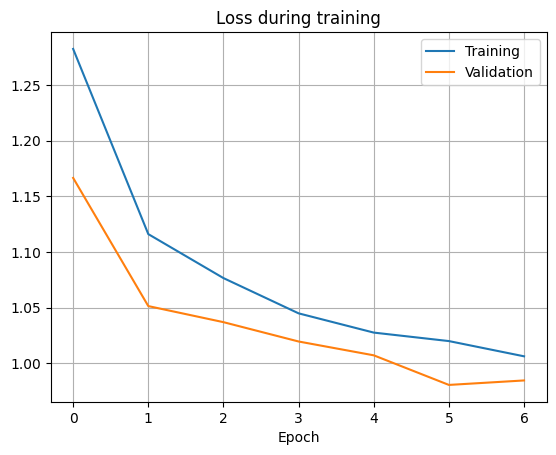

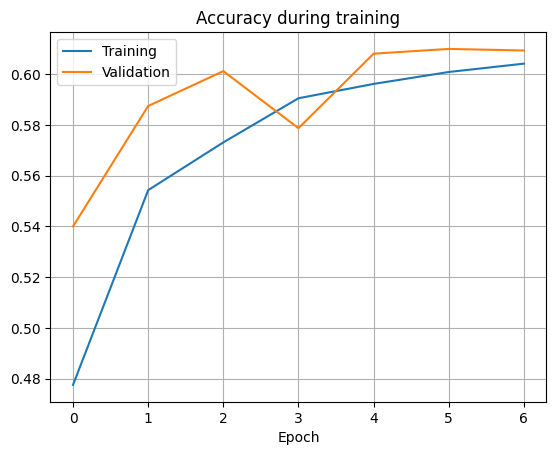

In [58]:
def display_history(history):
    loss_training = history.history['loss']
    met_training = history.history['accuracy']

    loss_val = history.history['val_loss']
    met_val = history.history['val_accuracy']

    # Graph of the loss on the training and validation set
    plt.plot(loss_training)
    plt.plot(loss_val)
    plt.grid()
    plt.title('Loss during training')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'])
    plt.show()

    # Graph of the accuracy on the training and validation set
    plt.plot(met_training)
    plt.plot(met_val)
    plt.grid()
    plt.title('Accuracy during training')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'])
    plt.show()

display_history(train_history)

Save the model for later reloading.

In [40]:
model.save_weights('model.h5')

We can now make predictions on the test dataset and get the accuracy for it.

In [41]:
y_predict = model.predict([test_input_ids, test_attn_masks])

136/136 [==============================] - 63s 440ms/step


In [59]:
predicted_labels = np.argmax(y_predict, axis=1)
sum = 0
for i in range(len(predicted_labels)):
  if(test_labels[i][predicted_labels[i]] == 1):
    sum+=1
accuracy = sum/len(test_labels)
print("Obtained accuracy of testing set: ", accuracy)

Obtained accuracy of testing set:  0.6018390804597701


We have a slightly lower testing accuracy than to the training one. Even though the accuracy might not look impressive, the problem itself is a difficult one as we already addressed the blurred lines between different genres. As a conclusion we can say that the results are satisfactory and for a proposal for future work, lyrics could be used as an important factor when classifying songs using sound which is the to-go method used nowadays.